# Toyota Yaris II -  price prediction (draft)


Notebook do analizy cen samochodu Yaris II

Podstawowe informacje:
 - rok produkcji: 2005–2011
 - silniki Benzyna, Diesel, Benzyna + LPG
 - Skrzynia biegów: 5MT, 6MT

| Model              | Pojemność | Cylindry | Moc                             | Moment obrotowy             | Skrzynia biegów    | Rok             |
|--------------------|-----------|----------|---------------------------------|-----------------------------|--------------------|-----------------|
| 1.0 VVT-i          | 998 cm³   | 3        | 51 kW (69 PS) przy 6000 min−1   | 93 Nm przy 3600 min−1       | 5MT                | 2005–2011       |
| 1.3 VVT-i          | 1298 cm³  | 4        | 64 kW (87 PS) przy 6000 min−1   | 121 Nm przy 4200 min−1      | 5MT / 5AT          | 2005–2008       |
| 1.33 Dual VVT-i    | 1329 cm³  | 4        | 73 kW (99 PS) przy 6000 min−1   | 128 Nm przy 3800 min−1      | 6MT / 6AT          | 09/2010–2011    |
|                    |           | 4        | 74 kW (101 PS) przy 6000 min−1  | 132 Nm przy 3800 min−1      | 6MT / 6AT          | 2009–09/2010    |
| 1.8 TS VVT-i       | 1798 cm³  | 4        | 98 kW (133 PS) przy 6000 min−1  | 173 Nm przy 4400 min−1      | 5MT / 6AT (Import) | 01/2007–01/2009 |
| 1.8 TS Bemani (CH) | 1798 cm³  | 4        | 158 kW (215 PS) przy 6000 min−1 | 270 Nm przy 4800 min−1      | 6MT                | 03/2009–2010    |
| 1.4 D-4D           | 1364 cm³  | 4        | 66 kW (90 PS) przy 3800 min−1   | 190 Nm przy 1800–3000 min−1 | 5MT / 5AT          | 2006–2009       |

## Wczytanie i przegląd danych

In [398]:
import pandas as pd
import numpy as np
import sqlite3

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

def get_view_data():
    sql_query = """SELECT * FROM v_cars"""
    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

def get_data():
    sql_query ="""
SELECT 
    all_offers.offer_id,otomoto_all.s_date, otomoto_all.e_date, all_offers.private_business, all_offers.region,
    all_offers.city, all_offers.model, all_offers.year, all_offers.mileage, all_offers.engine_capacity, all_offers.vin,
    all_offers.fuel_type, all_offers.engine_power, all_offers.gearbox, all_offers.transmission, all_offers.door_count,
    all_offers.nr_seats, all_offers.color, all_offers.features,otomoto_all.price, all_offers.price_raw, all_offers.currency, 
    all_offers.country_origin, all_offers.registration
FROM 
    otomoto_all, all_offers
WHERE 
    otomoto_all.uid = all_offers.uid; 
"""

    conn = sqlite3.connect("pythonsqlite.db")
    data = pd.read_sql_query(sql_query, conn)
    conn.close()
    return data

#%time df = get_data() #~13 ms
%time df = get_view_data() #~13 ms

#%time for i in range(3000): df = get_data()

df.head(3)

Wall time: 19 ms


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,transmission,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration
0,6005738641,2020-04-17,2020-05-26,business,malopolskie,krakow,yaris,2009,111000,1000,...,front-wheel,5,5,grey,0,6200,6200.0,0,f,0
1,6018694885,2020-04-17,2020-05-26,business,warminsko-mazurskie,ostroda,yaris,2008,45706,998,...,0,3,5,white,abs central-lock electronic-immobiliser front-...,4700,4700.0,0,pl,0
2,6025678407,2020-04-17,2020-05-26,business,mazowieckie,milanowek,yaris,2009,174000,1300,...,0,5,5,silver,abs cd central-lock front-electric-windows ele...,19800,19800.0,0,0,0


In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   offer_id          423 non-null    int64  
 1   s_date            423 non-null    object 
 2   e_date            423 non-null    object 
 3   private_business  423 non-null    object 
 4   region            423 non-null    object 
 5   city              423 non-null    object 
 6   model             423 non-null    object 
 7   year              423 non-null    int64  
 8   mileage           423 non-null    int64  
 9   engine_capacity   423 non-null    int64  
 10  vin               423 non-null    object 
 11  fuel_type         423 non-null    object 
 12  engine_power      423 non-null    int64  
 13  gearbox           423 non-null    object 
 14  transmission      423 non-null    object 
 15  door_count        423 non-null    int64  
 16  nr_seats          423 non-null    int64  
 1

In [400]:
def check_missing():
    for column in df.columns:
        missing = column, df[column].isnull().sum()
        if missing[1] == 0: continue

        print(missing)
        
check_missing()

In [489]:
feat_en_pl = {
    "abs" : "ABS",
    "cd" : "CD",
    "central-lock" : "Centralny zamek",
    "front-electric-windows" : "Elektryczne szyby przednie",
    "electronic-rearview-mirrors" : "Elektrycznie ustawiane lusterka",
    "electronic-immobiliser" : "Immobilizer",
    "front-airbags" : "Poduszka powietrzna kierowcy",
    "front-passenger-airbags" : "Poduszka powietrzna pasażera",
    "original-radio" : "Radio fabryczne",
    "assisted-steering" : "Wspomaganie kierownicy",
    "alarm" : "Alarm",
    "alloy-wheels" : "Alufelgi",
    "asr" : "ASR (kontrola trakcji)",
    "park-assist" : "Asystent parkowania",
    "lane-assist" : "Asystent pasa ruchu",
    "bluetooth" : "Bluetooth",
    "automatic-wipers" : "Czujnik deszczu",
    "blind-spot-sensor" : "Czujnik martwego pola",
    "automatic-lights" : "Czujnik zmierzchu",
    "both-parking-sensors" : "Czujniki parkowania przednie",
    "rear-parking-sensors" : "Czujniki parkowania tylne",
    "panoramic-sunroof" : "Dach panoramiczny",
    "electric-exterior-mirror" : "Elektrochromatyczne lusterka boczne",
    "electric-interior-mirror" : "Elektrochromatyczne lusterko wsteczne",
    "rear-electric-windows" : "Elektryczne szyby tylne",
    "electric-adjustable-seats" : "Elektrycznie ustawiane fotele",
    "esp" : "ESP (stabilizacja toru jazdy)",
    "aux-in" : "Gniazdo AUX",
    "sd-socket" : "Gniazdo SD",
    "usb-socket" : "Gniazdo USB",
    "towing-hook" : "Hak",
    "head-display" : "HUD (wyświetlacz przezierny)",
    "isofix" : "Isofix",
    "rearview-camera" : "Kamera cofania",
    "automatic-air-conditioning" : "Klimatyzacja automatyczna",
    "quad-air-conditioning" : "Klimatyzacja czterostrefowa",
    "dual-air-conditioning" : "Klimatyzacja dwustrefowa",
    "air-conditioning" : "Klimatyzacja manualna",
    "onboard-computer" : "Komputer pokładowy",
    "side-window-airbags" : "Kurtyny powietrzne",
    "shift-paddles" : "Łopatki zmiany biegów",
    "mp3" : "MP3",
    "gps" : "Nawigacja GPS",
    "dvd" : "Odtwarzacz DVD",
    "speed-limiter" : "Ogranicznik prędkości",
    "auxiliary-heating" : "Ogrzewanie postojowe",
    "heated-windshield" : "Podgrzewana przednia szyba",
    "heated-rearview-mirrors" : "Podgrzewane lusterka boczne",
    "front-heated-seats" : "Podgrzewane przednie siedzenia",
    "rear-heated-seats" : "Podgrzewane tylne siedzenia",
    "driver-knee-airbag" : "Poduszka powietrzna chroniąca kolana",
    "front-side-airbags" : "Poduszki boczne przednie",
    "rear-passenger-airbags" : "Poduszki boczne tylne",
    "tinted-windows" : "Przyciemniane szyby",
    "radio" : "Radio niefabryczne",
    "adjustable-suspension" : "Regulowane zawieszenie",
    "roof-bars" : "Relingi dachowe",
    "system-start-stop" : "System Start-Stop",
    "sunroof" : "Szyberdach",
    "daytime-lights" : "Światła do jazdy dziennej",
    "leds" : "Światła LED",
    "fog-lights" : "Światła przeciwmgielne",
    "xenon-lights" : "Światła Xenonowe",
    "leather-interior" : "Tapicerka skórzana",
    "velour-interior" : "Tapicerka welurowa",
    "cruise-control" : "Tempomat",
    "active-cruise-control" : "Tempomat aktywny",
    "tv" : "Tuner TV",
    "steering-whell-comands" : "Wielofunkcyjna kierownica",
    "cd-changer" : "Zmieniarka CD" }

## Porządkowanie danych

In [401]:
# offer_id - numer oferty
print('offer_id: ', df['offer_id'].dtypes)
print('offer_id: ', df['offer_id'].nunique(), 'MIN:', df['offer_id'].min(), 'MAX:', df['offer_id'].max())

df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')

offer_id:  int64
offer_id:  330 MIN: 6005738641 MAX: 6074808481


### s_date / e_date

In [402]:
# s_date - data publikacji ogłoszenia 
# e_date - data końca ogłoszenia

print('s_date: ', df['s_date'].dtypes)
print('e_date: ', df['e_date'].dtypes)

s_date:  object
e_date:  object


In [403]:
df['s_date'] = pd.to_datetime(df['s_date']) 
df['e_date'] = pd.to_datetime(df['e_date'])
print('s_date: ', df['s_date'].dtypes)
print('e_date: ', df['e_date'].dtypes)

s_date:  datetime64[ns]
e_date:  datetime64[ns]


### private_business

private_business:
 business    220
private     203
Name: private_business, dtype: int64


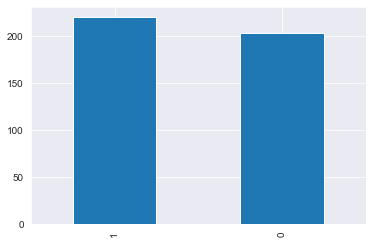

In [404]:
#print('private_business: ', df['private_business'].dtypes)
print('private_business:\n', df['private_business'].value_counts()) # business : 1 / private : 0

if df['private_business'].dtypes == 'object':
    df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business' )
    df['private_business'] = df['private_business'].astype(np.int8)

df['private_business'].value_counts().plot(kind='bar');

### Region / City / Model

In [405]:
# region 
print('region: ', df['region'].dtypes)
print('region: ', df['region'].unique())

region:  object
region:  ['malopolskie' 'warminsko-mazurskie' 'mazowieckie' 'dolnoslaskie'
 'wielkopolskie' 'slaskie' 'podkarpackie' 'podlaskie' 'lodzkie'
 'zachodniopomorskie' 'lubelskie' 'swietokrzyskie' 'opolskie'
 'kujawsko-pomorskie' 'lubuskie' 'pomorskie']


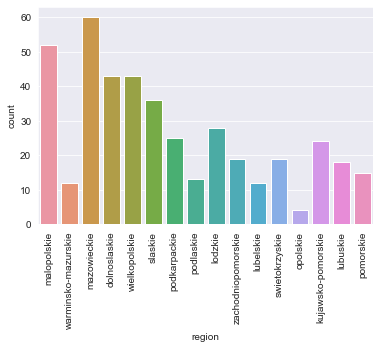

In [406]:
chart = sns.countplot(x='region', data=df)
chart.set_xticklabels(chart.get_xticklabels(), rotation = 90);

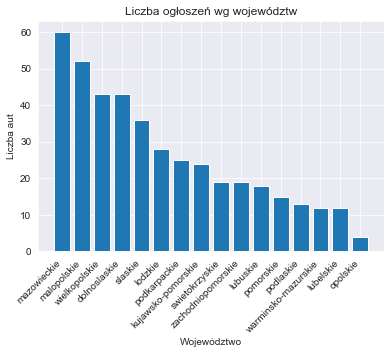

In [407]:
counts = df['region'].value_counts()

fig = plt.figure()
axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
axes.bar(counts.index, counts.values)

axes.set_xlabel('Województwo')
axes.set_ylabel('Liczba aut')
axes.set_title('Liczba ogłoszeń wg województw')

for label in axes.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [408]:
# city
print('city: ', df['city'].dtypes)
print('city: ', df['city'].nunique())

city:  object
city:  163


In [409]:
# model
print('model: ', df['model'].dtypes)
print('model: ', df['model'].unique())

model:  object
model:  ['yaris']


In [410]:
# year - lata produkcji Yaris II: 2005 - 2011
print('year: ', df['year'].dtypes)
print('year: ', df['year'].unique())

year:  int64
year:  [2009 2008 2006 2005 2007 2010 2011 2002 2014 2016]


In [411]:
# mileage
print('mileage: ', df['mileage'].dtypes)
print('mileage: ', df['mileage'].nunique())
print('MIN: ', df['mileage'].min(), 'MAX: ', df['mileage'].max())

mileage:  int64
mileage:  234
MIN:  9100 MAX:  410000


### Engine Capacity

In [412]:
# engine capacity

car = {
    "R3_10_69KM" : {"power" : 69 , "fuel" : "petrol", "capacity": 998, "gearbox" : "5MT", "Date" : "2005-2011"},
    "R4_13_86KM" : {"power" : 86 , "fuel" : "petrol", "capacity": 1296, "gearbox" : "5MT", "Date" : "2005-2008"},
    "R4_133_99KM" : {"power" : 101 , "fuel" : "petrol", "capacity": 1329, "gearbox" : "6MT", "Date" : "09/2010 - 2011"},
    "R4_133_101KM" : {"power" : 101 , "fuel" : "petrol", "capacity": 1329, "gearbox" : "6MT", "Date" : "2009 - 09/2010"},
    "R4_18_133KM" : {"power" : 133 , "fuel" : "petrol", "capacity": 1798, "gearbox" : "6MT", "Date": "01/2007 - 01/2009"},
    "R4_18_215KM" : {"power" : 215 , "fuel" : "petrol", "capacity": 1798, "gearbox" : "6MT", "Date" : "03/2009 - 2010"},
    "R4_14_D4D" : {"power" : 90 , "fuel" : "diesel", "capacity": 1364, "gearbox" : "5MT", "Date" : "2006 - 2009"}    
}

print('engine_capacity: ', df['engine_capacity'].dtypes)
print('engine_capacity: ', df['engine_capacity'].unique())

engine_capacity:  int64
engine_capacity:  [1000  998 1300 1364 1298 1400 1398 1329    0 1798 1323  966 1324  996
  988 1332 1296 1330  999 1290 1335 1333]


Wg portalu Autocentrum w tym modelu były dostępne następujące wersje silnikowe:

Benzyna:
- 1.0  VVT-i      69KM 51kW (2005-2011) - 998 cm3, 5MT

- 1.3i VVT-i      86KM 63kW (2005-2010) - 1296 cm3, 5MT

- 1.33 Dual VVT-i 101KM 74kW (2009-2011) - 1329 cm3, 6MT

- 1.8i VVT-i      133KM 98kW (2005-2010) - 1798 cm3, 6MT

Diesel:
- 1.4 D-4D 90KM 66kW (2005-2011) - 1364 cm3, 5MT

In [413]:
feats = ["engine_capacity", "fuel_type", "engine_power", "gearbox", "year"]
df[feats][df.engine_capacity == 1400]

,engine_capacity,fuel_type,engine_power,gearbox,year
7,1400,diesel,0,manual,2009
20,1400,diesel,90,manual,2009
30,1400,diesel,90,manual,2009
33,1400,diesel,90,manual,2009
35,1400,diesel,90,manual,2008
36,1400,diesel,90,manual,2008
40,1400,diesel,90,manual,2007
43,1400,diesel,90,manual,2009
44,1400,petrol,87,manual,2008
80,1400,diesel,90,manual,2011


In [414]:
def get_engine_code(engine_capacity, fuel_type, engine_power, year):
    if (engine_capacity <= 1000) & (fuel_type[0:6] == 'petrol'):
        return 'R3_10_69KM'
    elif ( 1000 <= engine_capacity <= 1350) & (fuel_type[0:6] == 'petrol') & (engine_power < 80):
        return 'R4_13_86KM'
    elif (year <= 2008) & (fuel_type[0:6] == 'petrol') & (engine_power < 95):
        return 'R4_13_86KM'
    elif (year >= 2009) & (fuel_type[0:6] == 'petrol') & (95 <= engine_power < 99):
        return 'R4_133_99KM'
    elif (year >= 2009) & (fuel_type[0:6] == 'petrol') & (99 <= engine_power < 110):
        return 'R4_133_101KM'
    elif (engine_capacity >= 1400) & (fuel_type[0:6] == 'petrol'):
        return 'R4_18_133KM'
    elif fuel_type[0:6] == 'diesel':
        return 'R4_14_D4D'
    elif engine_power > 150:
        return 'R4_18_215KM'
    else:
        return 'NA'
    
df['engine'] = df.apply(lambda x: get_engine_code(x['engine_capacity'], x['fuel_type'], x['engine_power'], x['year']), axis=1)

In [415]:
feats = ["offer_id","engine","engine_capacity", "fuel_type", "engine_power", "gearbox", "year"]
df[feats][df.engine == 'NA']

,offer_id,engine,engine_capacity,fuel_type,engine_power,gearbox,year
3,6027129122,NA,1300,petrol,87,manual,2009
47,6061613472,NA,1300,petrol,90,manual,2010
58,6065067561,NA,1300,petrol,87,manual,2009
63,6065479018,NA,1300,petrol,86,manual,2009
112,6068481479,NA,1324,petrol,100,manual,2008
172,6069517302,NA,1300,petrol,87,manual,2009
173,6069517302,NA,1300,petrol,87,manual,2009
174,6069528428,NA,1300,petrol,86,manual,2009
283,6071596035,NA,1290,petrol,90,manual,2011
295,6071810147,NA,1329,petrol,100,manual,2008


### VIN

In [416]:
# vin
print('vin: ', df['vin'].dtypes)
print('vin: ', df['vin'].unique())

vin:  object
vin:  ['0']


W żadnym ogłoszeniu nie był podany numer VIN

fuel_type:  object
fuel_type:  ['petrol' 'diesel' 'petrol-lpg']


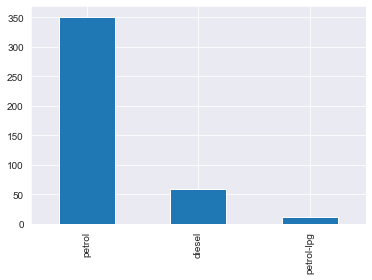

In [417]:
# fuel_type
print('fuel_type: ', df['fuel_type'].dtypes)
print('fuel_type: ', df['fuel_type'].unique())

df['fuel_type'].value_counts().plot(kind='bar');

In [418]:
# engine_power - Moc W KM
# 1kW = 1,36 KM
# Powinno być: Benzyna: 69, 86, 101,133 Diesel: 90 

print('engine_power: ', df['engine_power'].dtypes)
print('engine_power: ', df['engine_power'].unique())


engine_power:  int64
engine_power:  [  0 100  87  90  86  69 101  70  82 133  68  85  88  80  66  99  72  65
 103  97  67  51]


In [419]:
# gearbox

print('gearbox: ', df['gearbox'].dtypes)
print('gearbox: ', df['gearbox'].unique())
df[(df.gearbox == 'semi-automatic') | (df.gearbox == 'automatic') | (df.gearbox == 'automatic-sequential')]  # 4 samochody z automatyczną skrzynią


gearbox:  object
gearbox:  ['manual' 'semi-automatic' '0' 'automatic' 'automatic-sequential']


,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration,engine
42,6060165978,2020-04-17,2020-05-26,1,podkarpackie,ropczyce,yaris,2008,195000,1298,...,5,5,blue,abs cd central-lock front-electric-windows ele...,18900,18900.0,0,i,0,R4_13_86KM
69,6065928866,2020-04-17,2020-05-25,0,wielkopolskie,kepno,yaris,2009,90000,1323,...,5,5,grey,abs cd central-lock front-electric-windows ele...,18888,18888.0,0,d,0,R4_133_101KM
285,6071670143,2020-04-17,2020-05-26,1,lubuskie,sulechow,yaris,2010,94000,998,...,0,0,grey,abs cd central-lock front-electric-windows ele...,18600,18600.0,0,0,0,R3_10_69KM
338,6072328903,2020-04-17,2020-05-12,1,podkarpackie,stalowa-wola,yaris,2006,86000,1300,...,5,5,grey,abs cd central-lock front-electric-windows ele...,16900,16900.0,0,0,0,R4_13_86KM


In [420]:
df[(df.gearbox == '0')]

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration,engine
52,6064681017,2020-04-25,2020-05-24,0,warminsko-mazurskie,olsztyn,yaris,2009,162500,0,...,0,0,grey,abs cd central-lock front-electric-windows ele...,13900,13900.0,0,0,0,R3_10_69KM
98,6067916286,2020-04-17,2020-05-26,1,wielkopolskie,gniezno,yaris,2010,130500,1300,...,0,0,blue,abs cd central-lock front-electric-windows ele...,16500,16500.0,0,0,0,R4_133_101KM
191,6069930254,2020-05-26,2020-05-26,0,slaskie,zawiercie,yaris,2006,340000,0,...,0,0,silver,abs cd central-lock front-electric-windows ele...,8500,8500.0,0,0,0,R4_14_D4D
203,6070077979,2020-04-17,2020-05-26,0,dolnoslaskie,sroda-slaska,yaris,2006,138000,0,...,0,0,blue,abs cd electronic-immobiliser front-airbags or...,12900,12900.0,0,0,0,R3_10_69KM
241,6070885427,2020-04-17,2020-05-26,1,podlaskie,zambrow,yaris,2010,147893,0,...,5,0,black,abs cd central-lock front-electric-windows ele...,15500,15500.0,0,0,0,R3_10_69KM
242,6070891090,2020-04-17,2020-05-26,1,slaskie,chorzow,yaris,2009,170000,1300,...,5,5,grey,abs cd central-lock front-electric-windows ele...,14800,14800.0,0,0,0,R4_14_D4D
250,6070974665,2020-04-25,2020-05-26,0,mazowieckie,warszawa,yaris,2008,129000,0,...,5,5,silver,0,15900,15900.0,0,0,0,R3_10_69KM
258,6071202971,2020-04-17,2020-05-13,0,dolnoslaskie,legnica,yaris,2008,147245,0,...,5,5,grey,0,13900,13900.0,0,0,0,R3_10_69KM
289,6071690808,2020-04-17,2020-05-08,0,lodzkie,lodz,yaris,2009,181000,0,...,0,0,grey,0,14500,14500.0,0,0,0,R4_14_D4D
290,6071735591,2020-04-17,2020-05-08,0,mazowieckie,warszawa,yaris,2005,242605,0,...,0,0,white,0,5500,5500.0,0,0,0,R3_10_69KM


transmission:  object
transmission:  ['front-wheel' '0' 'rear-wheel']


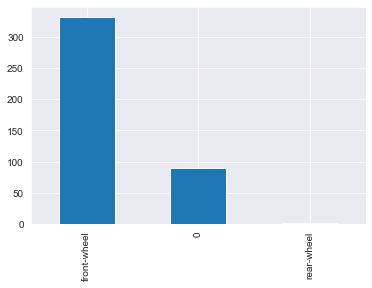

In [421]:
# transmission
# Yaris II występował wyłącznie z napędem na przód

print('transmission: ', df['transmission'].dtypes)
print('transmission: ', df['transmission'].unique())

df['transmission'].value_counts().plot(kind='bar');

door_count:  int64
door_count:  [5 3 0 4 2]


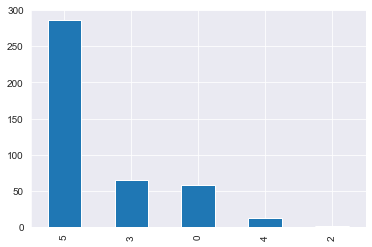

In [422]:
# door_count
print('door_count: ', df['door_count'].dtypes)
print('door_count: ', df['door_count'].unique())

df['door_count'].value_counts().plot(kind='bar');

In [423]:
df[(df.door_count == 2)]

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration,engine
197,6070014532,2020-05-19,2020-05-26,0,wielkopolskie,turek,yaris,2008,320000,998,...,2,4,red,abs cd central-lock electronic-rearview-mirror...,6500,6500.0,0,pl,0,R3_10_69KM


nr_seats:  int64
nr_seats:  [5 0 6 4 2]


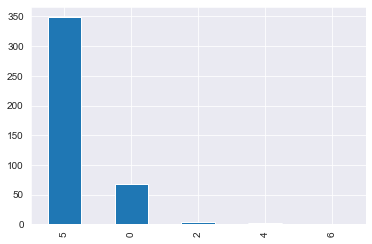

In [424]:
# nr_seats
print('nr_seats: ', df['nr_seats'].dtypes)
print('nr_seats: ', df['nr_seats'].unique())
df['nr_seats'].value_counts().plot(kind='bar');

In [425]:
df[(df.nr_seats == 2)]

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,door_count,nr_seats,color,features,price,price_raw,currency,country_origin,registration,engine
93,6067672282,2020-04-17,2020-05-09,1,wielkopolskie,ostrzeszow,yaris,2007,410000,998,...,3,2,silver,abs cd central-lock electronic-immobiliser fro...,5400,4390.24,0,pl,0,R3_10_69KM
113,6068534064,2020-04-17,2020-05-26,1,lubuskie,zielonagora,yaris,2010,147218,996,...,5,2,other,abs cd central-lock front-electric-windows ele...,22000,22000.00,0,d,FZ7496M,R3_10_69KM
339,6072329710,2020-04-17,2020-05-26,1,wielkopolskie,ostrzeszow,yaris,2009,390000,998,...,3,2,silver,abs cd central-lock front-electric-windows el...,6500,5284.55,0,0,0,R3_10_69KM
340,6072329710,2020-04-17,2020-05-26,1,wielkopolskie,ostrzeszow,yaris,2009,390000,998,...,3,2,silver,abs cd central-lock front-electric-windows ele...,6500,5609.76,0,0,0,R3_10_69KM


In [426]:
# color
print('color: ', df['color'].dtypes)
print('color: ', df['color'].unique())

color:  object
color:  ['grey' 'white' 'silver' 'red' 'blue' 'other' 'black' 'yellow-gold'
 'green' 'yellow' 'brown-beige' 'violet']


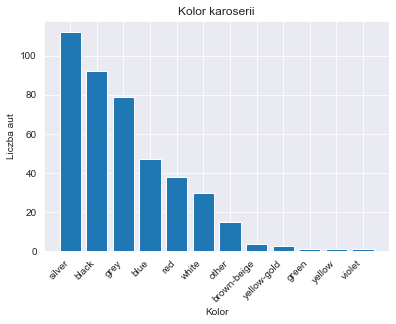

In [427]:
color_cnt = df['color'].value_counts()

fig = plt.figure()
axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
axes.bar(color_cnt.index, color_cnt.values)

axes.set_xlabel('Kolor')
axes.set_ylabel('Liczba aut')
axes.set_title('Kolor karoserii')

for label in axes.get_xticklabels():
  label.set_rotation(45)
  label.set_ha('right')

In [428]:
# price
print('price: ', df['price'].dtypes)
print('price: ', df['price'].nunique())

# price_raw
print('price_raw: ', df['price_raw'].dtypes)
print('price_raw: ', df['price_raw'].nunique())

price:  int64
price:  110
price_raw:  float64
price_raw:  130


In [429]:
# currency
print('currency: ', df['currency'].dtypes)
print('currency: ', df['currency'].unique())

currency:  object
currency:  ['0']


In [430]:
# country_origin
print('country_origin: ', df['country_origin'].dtypes)
print('country_origin: ', df['country_origin'].unique())

countries = {
    'f' : 'France',
    'pl' : 'Poland',
    'd' : 'Germany',
    'b' : 'Belgium',
    'nl' : 'Nederlands',
    'a': 'Austria',
    'i' : 'Italy',
    'gb' : 'Great Britan',
    'dk' : 'Denmark',
    's' : 'Sweden'
}

country_origin:  object
country_origin:  ['f' 'pl' '0' 'd' 'b' 'nl' 'a' 'i' 'gb' 'dk' 's']


In [431]:
# registration
print('registration: ', df['registration'].dtypes)
print('registration: ', df['registration'].unique())

registration:  object
registration:  ['0' 'RST19536' 'ZGR VH37' 'RZE68062' 'FZ7305M' 'FZ7556M' 'ZDR 16488'
 'FZ7496M' 'WWL76138' 'K WV2222' 'LRY 84LR' 'KBC 72163' 'DJ91837'
 'TKI8551A' 'XGK506' 'RZE 74732' 'CG34523' 'RBR28917' 'ZMY 705AJ' 'XUM146'
 'FNW53TF' 'WY 98871' 'FMI 54886' 'WZY11627' 'TK 2396F' 'PK6174K'
 'N-JI164']


---

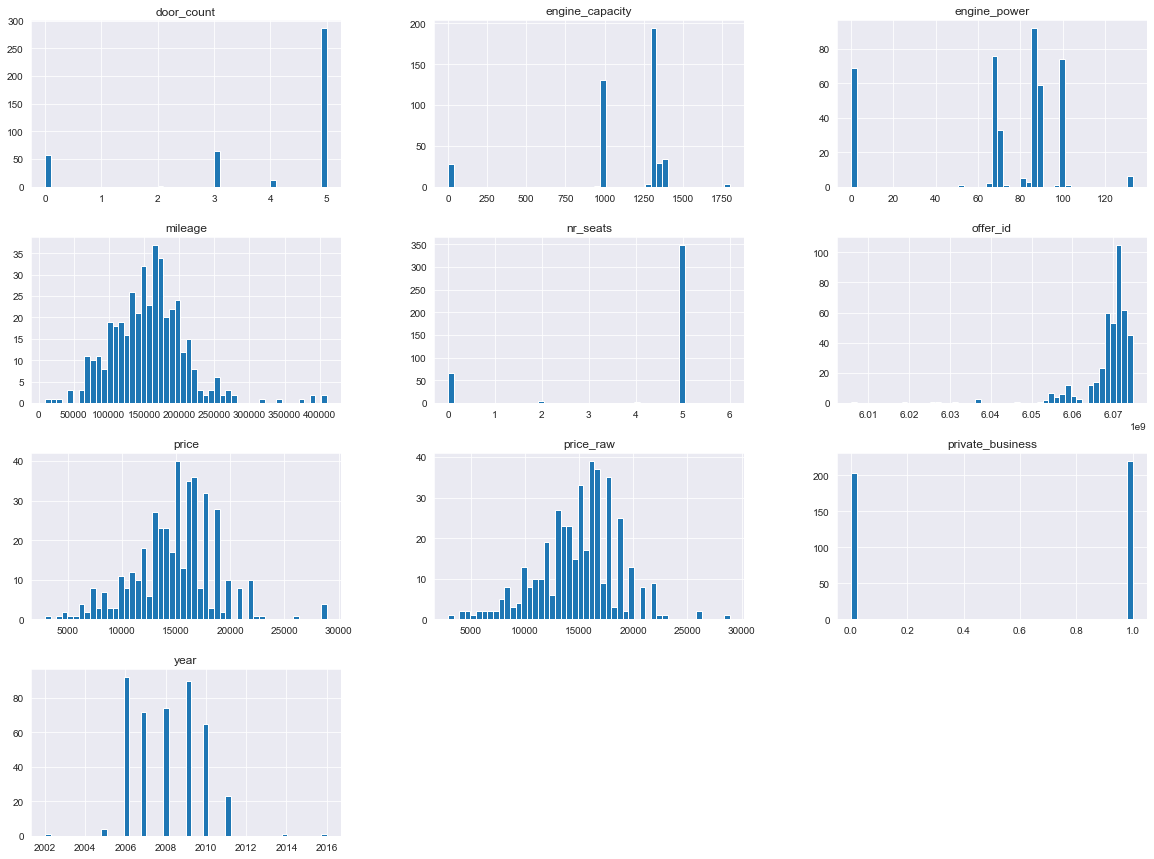

In [432]:
df.hist(bins=50,figsize=(20,15))
plt.show()

In [433]:
def optimize_df():
    #df['offer_id'] = df['offer_id'].astype(np.uint32)
    df['offer_id'] = pd.to_numeric (df['offer_id'], downcast='unsigned')
    df['s_date'] = pd.to_datetime(df['s_date']) 
    df['e_date'] = pd.to_datetime(df['e_date']) 
    df['private_business'] = df['private_business'].apply(lambda x : str(x) == 'business')
    df['year'] = pd.to_numeric(df['year'], downcast='unsigned')
    df['mileage'] = pd.to_numeric(df['mileage'], downcast='unsigned')
    df['engine_capacity'] = pd.to_numeric(df['engine_capacity'], downcast='unsigned')
    df['engine_power'] = pd.to_numeric(df['engine_power'], downcast='unsigned')
    df['door_count'] = pd.to_numeric(df['door_count'], downcast='unsigned')
    df['nr_seats'] = pd.to_numeric(df['nr_seats'], downcast='unsigned')
    df['price'] = pd.to_numeric(df['price'], downcast='float')
    df['price_raw'] = pd.to_numeric(df['price_raw'], downcast='float')
    
%time optimize_df()    

Wall time: 12 ms


## Feature engineering

In [434]:
def general_features():
    df['duration'] = (df['e_date'] - df['s_date']).dt.days.astype(np.uint16)
    df['price_chng'] = (df['price'] - df['price_raw'])
    #df['active'] = df['duration'].apply()
    
%time general_features()

Wall time: 3 ms


In [435]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,color,features,price,price_raw,currency,country_origin,registration,engine,duration,price_chng
371,6073394702,2020-04-17,2020-05-07,False,dolnoslaskie,sycow,yaris,2010,150000,1000,...,black,abs cd central-lock front-electric-windows ele...,15200.0,14900.0,0,pl,0,R3_10_69KM,20,300.0
114,6068559140,2020-04-17,2020-05-24,False,malopolskie,limanowa,yaris,2007,100000,1300,...,grey,abs cd central-lock front-electric-windows ele...,14900.0,14900.0,0,0,0,R4_13_86KM,37,0.0
326,6072214221,2020-04-17,2020-05-04,False,wielkopolskie,chodziez,yaris,2009,90200,1400,...,grey,0,14900.0,14900.0,0,f,0,R4_14_D4D,17,0.0


In [436]:
# Price change
df[df['price_chng']!=0].head()

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,color,features,price,price_raw,currency,country_origin,registration,engine,duration,price_chng
6,6036867722,2020-04-17,2020-05-09,False,slaskie,raciborz,yaris,2008,153000,1298,...,red,abs cd central-lock front-electric-windows ele...,13900.0,14900.0,0,d,0,R4_13_86KM,22,-1000.0
13,6054649805,2020-04-20,2020-05-26,False,podlaskie,suwalki,yaris,2007,178560,1300,...,silver,abs cd central-lock front-electric-windows ele...,14900.0,15900.0,0,d,0,R4_13_86KM,36,-1000.0
14,6054649805,2020-04-20,2020-05-26,False,podlaskie,suwalki,yaris,2007,178560,1300,...,silver,abs cd central-lock front-electric-windows ele...,14900.0,16600.0,0,d,0,R4_13_86KM,36,-1700.0
28,6058167820,2020-04-27,2020-05-26,False,wielkopolskie,poznan,yaris,2006,77000,998,...,silver,abs cd central-lock electronic-rearview-mirror...,12900.0,13600.0,0,0,0,R3_10_69KM,29,-700.0
36,6059219052,2020-04-17,2020-05-26,False,wielkopolskie,krotoszyn,yaris,2008,187000,1400,...,black,abs cd central-lock front-electric-windows ele...,13500.0,13800.0,0,f,0,R4_14_D4D,39,-300.0


In [437]:
#car features
def benefits_to_set(value):
    if str(value) == 'nan': return set(["nan"])
    return {attr.lower().strip() for attr in value}
    
def norm_name(name):
    return 'f_{0}'.format( name.lower().strip() )

def feature_columns(): 
    benefits_series = df['features'].str.split(' ').map(benefits_to_set)
    all_benefits = {benefit for row in benefits_series for benefit in row}
    
    feat_names = [norm_name(x) for x in all_benefits]
    
    for benefit in all_benefits:
        df[ norm_name(benefit) ] = benefits_series.map(lambda x: benefit in x).astype(np.int8)
    
    return feat_names

%time f = feature_columns()

Wall time: 66 ms


In [438]:
def old_plot(f):
    df[f].hist(bins=2,figsize=(20,20))
    plt.show()

# %time old_plot(f)

Wall time: 784 ms


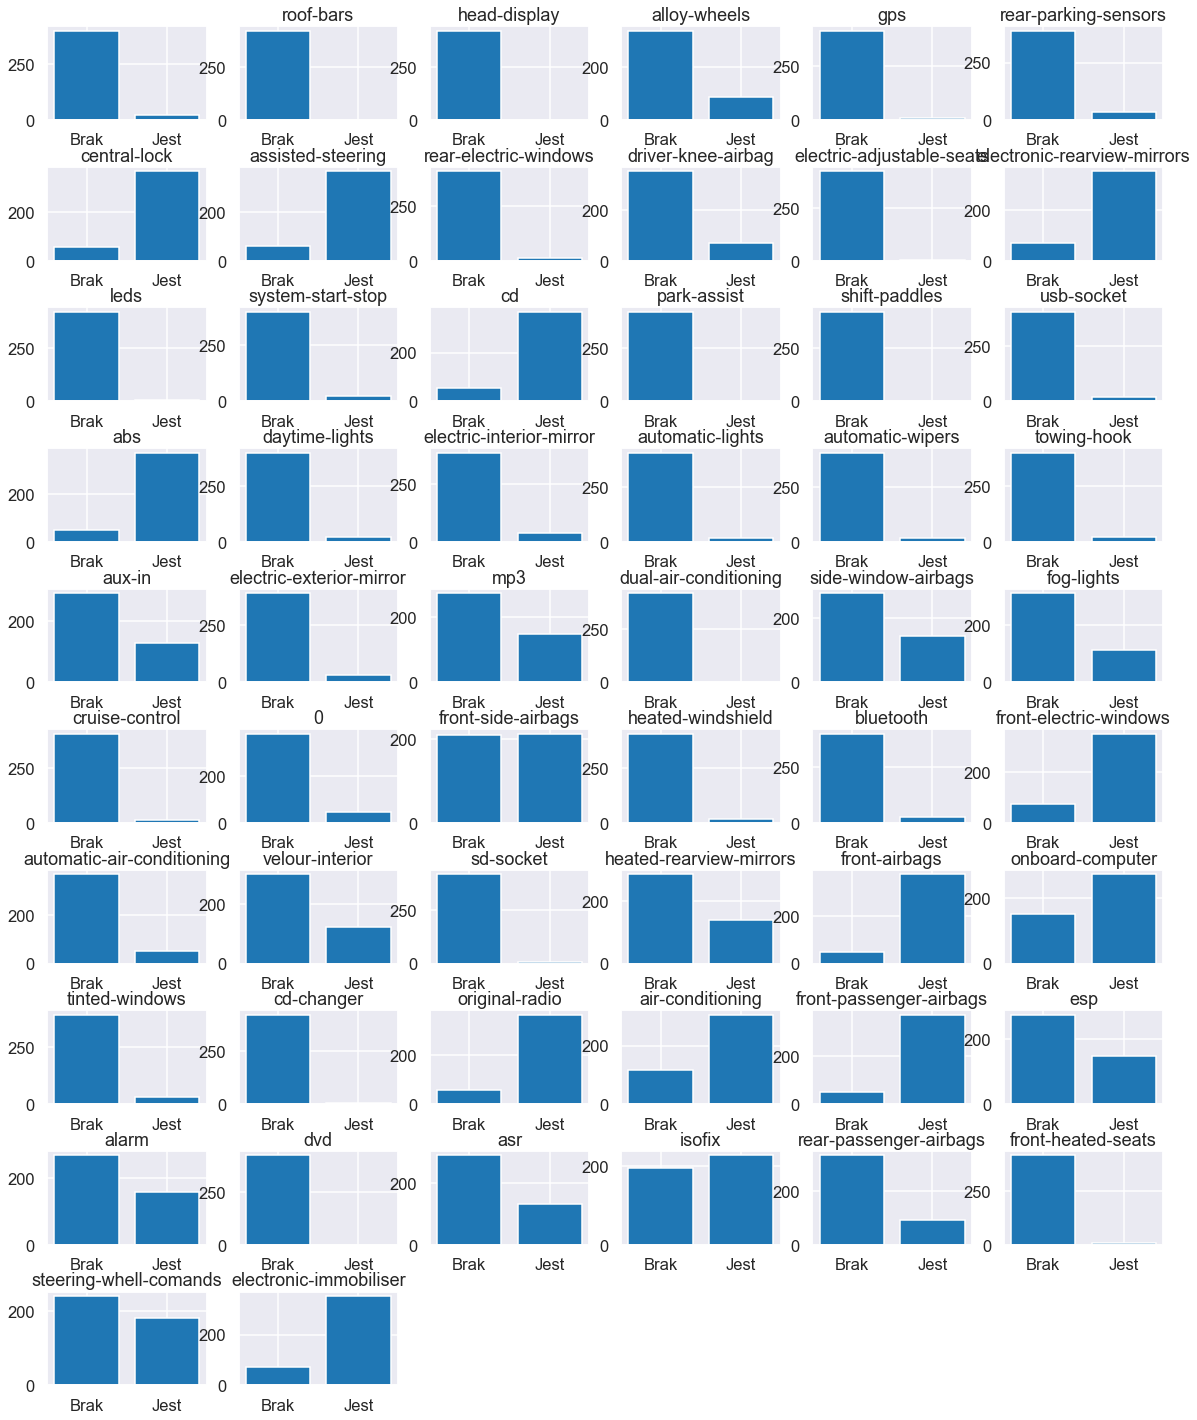

In [495]:
def new_plot(f):
    fig = plt.figure(figsize=(20, 25))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    fig.add_axes([0.1 ,0.1 ,0.8, 0.8])
    for i in range(len(f)):
        cnt = df[f[i]].value_counts()
        plt.subplot(10,6,i+1)
        plt.xticks(np.arange(2), ['Brak', 'Jest'])
        plt.bar(cnt.index, cnt.values, align='center')
        key = f[i][2:]
        plt.title(key)
        #plt.title(feat_en_pl.get(key))

%time new_plot(f)

In [440]:
# return only not empty columns
def non_empty_feats():
    for col in df.columns: 
        if col[0:2] == 'f_':
            if df[col].nunique() != 0:
                print(col)
                
# non_empty_feats()                

In [441]:
df.sample(3)

,offer_id,s_date,e_date,private_business,region,city,model,year,mileage,engine_capacity,...,f_front-passenger-airbags,f_esp,f_alarm,f_dvd,f_asr,f_isofix,f_rear-passenger-airbags,f_front-heated-seats,f_steering-whell-comands,f_electronic-immobiliser
44,6060368475,2020-05-01,2020-05-26,False,swietokrzyskie,pinczow,yaris,2008,156669,1400,...,1,1,1,0,0,1,1,0,1,1
201,6070033906,2020-04-17,2020-05-26,False,dolnoslaskie,jelenia-gora,yaris,2010,117000,1329,...,1,0,0,0,0,0,0,0,1,1
391,6073829244,2020-04-23,2020-05-26,False,mazowieckie,kobylka,yaris,2010,193000,1400,...,1,0,1,0,0,0,0,0,0,1


## Wizualizacja

In [442]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.plotting import figure 
import bokeh_catplot
from bokeh.io import output_notebook, show


output_notebook(resources=None, verbose=False, hide_banner=True)

### Plotly

In [443]:
# "Regular" Plotly

import plotly.graph_objects as go
import plotly.io as pio
print(pio.templates)


Templates configuration
-----------------------
    Default template: 'plotly'
    Available templates:
        ['ggplot2', 'seaborn', 'simple_white', 'plotly',
         'plotly_white', 'plotly_dark', 'presentation', 'xgridoff',
         'ygridoff', 'gridon', 'none']



In [444]:
fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
fig.show()

### Plotly express

In [445]:
import plotly
import plotly.express as px


def px_to_file():
    # Use directly Columns as argument. You can use tab completion for this!
    plt_sca_year = px.scatter(df, x=df.year, y=df.price_raw, template="presentation")
    plt_sca_year.show()

    #plotly.offline.plot(fig, "file.html")
    pio.write_html(plt_sca_year, file='./img/plt_sca_year.html', full_html=False, include_plotlyjs='cdn', auto_open=False)
    
%time px_to_file() 

Wall time: 307 ms


In [446]:
plt_price = px.histogram(df, x=df.price, template="presentation")
plt_price.show()

pio.write_html(plt_price, file='./img/plt_price.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

In [447]:
plt_mileage = px.histogram(df, x=df.mileage, template="presentation")
plt_mileage.show()

pio.write_html(plt_mileage, file='./img/plt_mileage.html', full_html=False, include_plotlyjs='cdn', auto_open=False)

In [448]:
def plot_bokeh():
    p = figure(plot_width=400, plot_height=400)
    p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)
    show(p)

def plot_hist():
    # http://justinbois.github.io/bootcamp/2019/lessons/l23_high_level_plotting.html
    # https://github.com/justinbois/bokeh-catplot
    p = bokeh_catplot.histogram(data=df['price'],cats=None,val='price', bins=20)
    show(p)

#%time plot_bokeh() 
%time plot_hist()

Wall time: 41 ms


### Cena

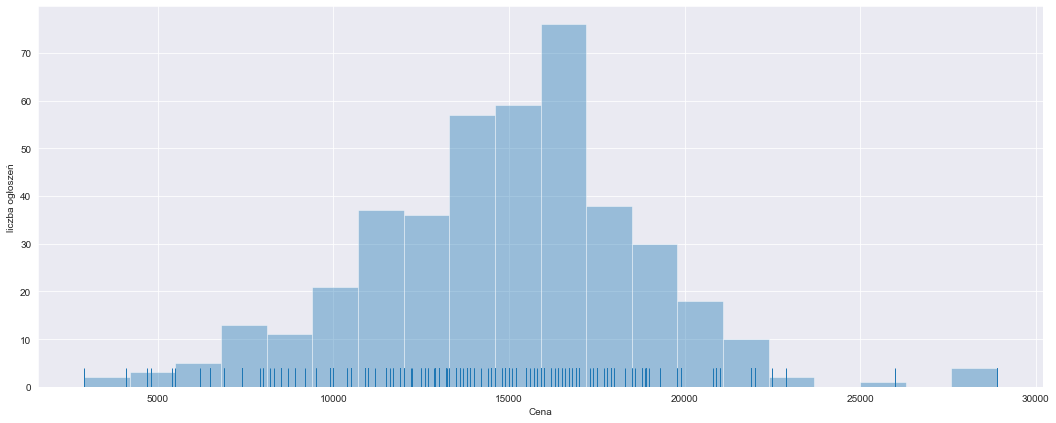

In [449]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['price'], bins=20, kde=False, rug=True)
chart.set(xlabel='Cena', ylabel='liczba ogłoszeń');

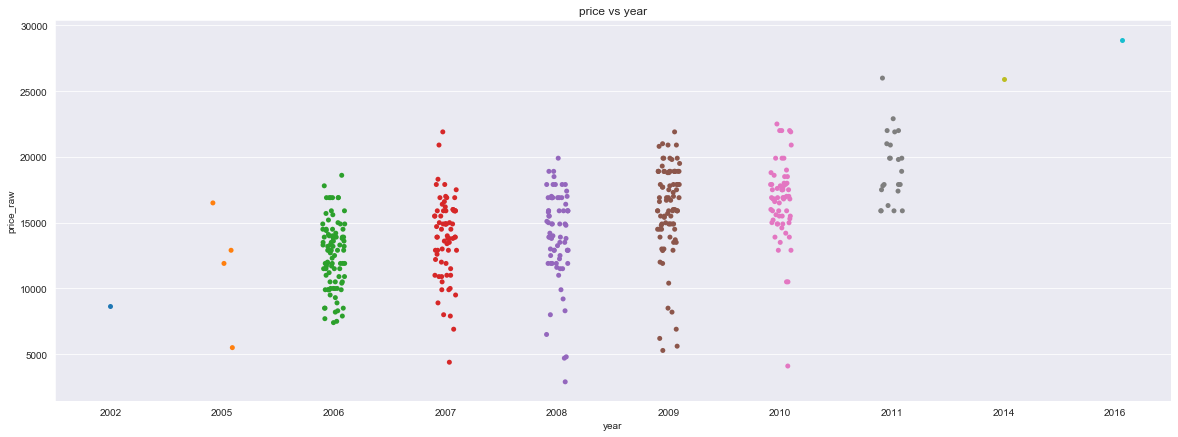

In [450]:
plt.figure(figsize=(20, 7))
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price') 
sns.stripplot(x="year", y="price_raw", data=df);

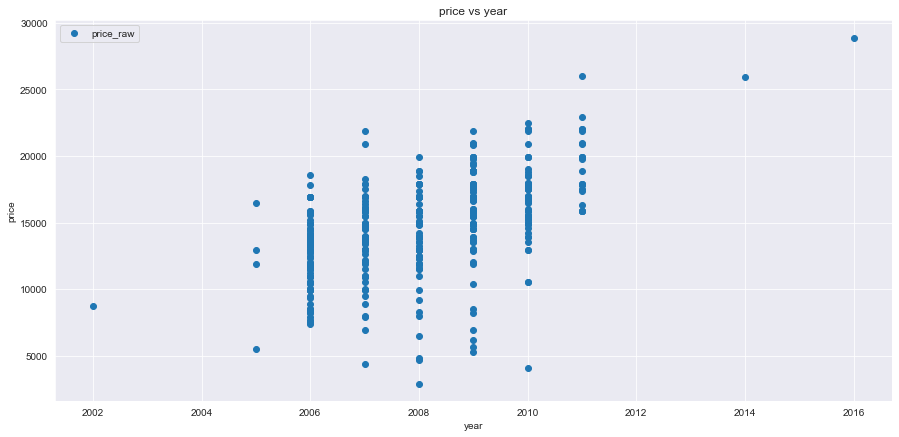

In [451]:
df.plot(x='year', y='price_raw', style='o', figsize=(15,7)) 
plt.title('price vs year')  
plt.xlabel('year')  
plt.ylabel('price')  
plt.show()

### przebieg

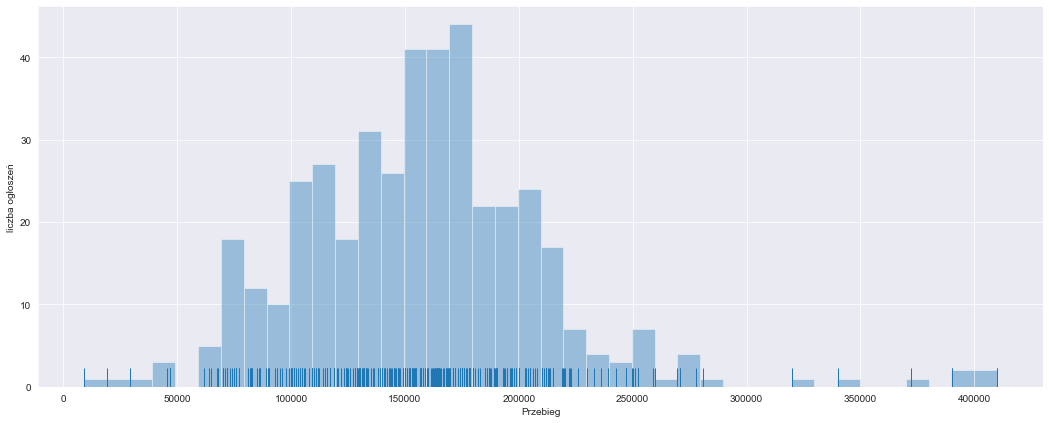

In [452]:
sns.set_style("darkgrid")
plt.figure(figsize=(18,7))
chart = sns.distplot(df['mileage'], bins=40, kde=False, rug=True)
chart.set(xlabel='Przebieg', ylabel='liczba ogłoszeń');

### Czas trwania ogłoszenia

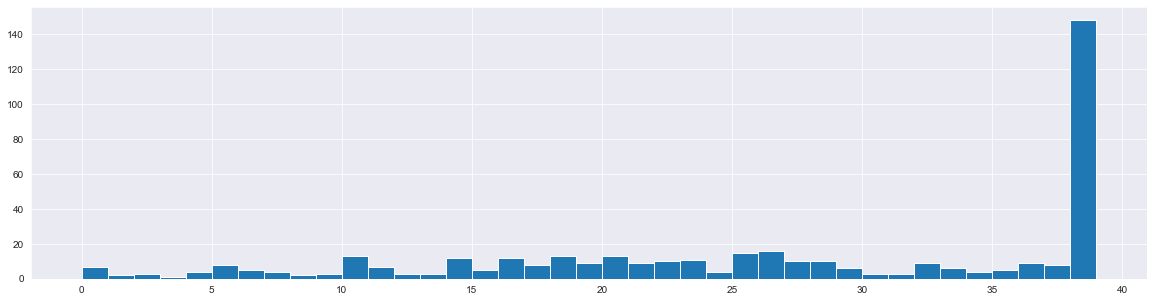

In [453]:
offer_duration = df['duration'].max()
df['duration'].hist(bins=offer_duration,figsize=(20,5))
plt.show()

In [454]:
# counts = df['duration'].value_counts()

# fig = plt.figure(figsize=(20,5))
# axes = fig.add_axes([0.1 ,0.1 ,0.8, 0.8]) 
# axes.bar(counts.index, counts.values)

# axes.set_xlabel('Województwo')
# axes.set_ylabel('Liczba aut')
# axes.set_title('Liczba ogłoszeń wg województw')

# locs, labels = fig.xticks() 

# # for label in axes.get_xticklabels():
# #     xticks(np.arange(30))
# # #   label.set_rotation(45)
# # #   label.set_ha('right')

### Cena końcowa - 99 percentyl

In [455]:
filter_max = np.percentile(df['price'],99)
filter_max

25310.199999999917

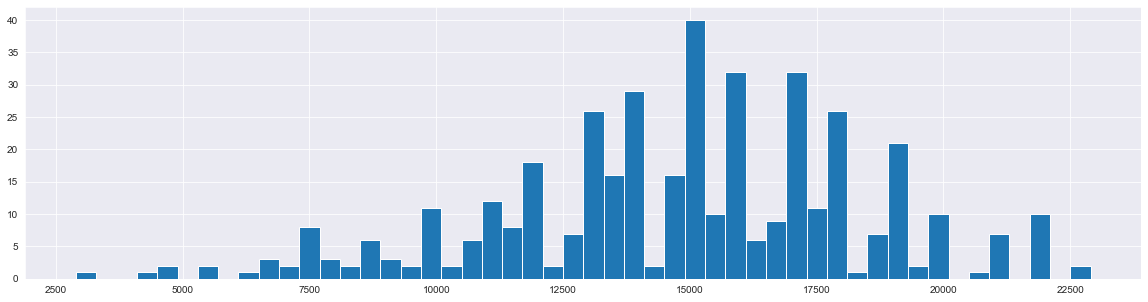

In [456]:
df_filter = df[df['price'] < filter_max]
df_filter['price'].hist(bins=50,figsize=(20,5))
plt.show()

### Przebieg

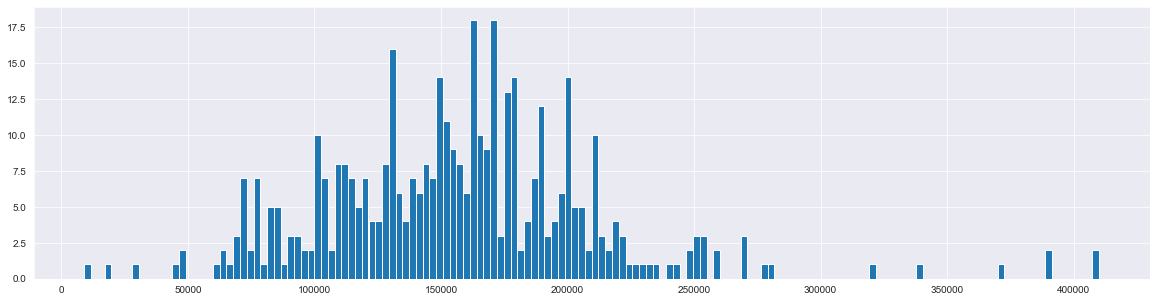

In [457]:
df['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

### Przebieg - 99 percentyl

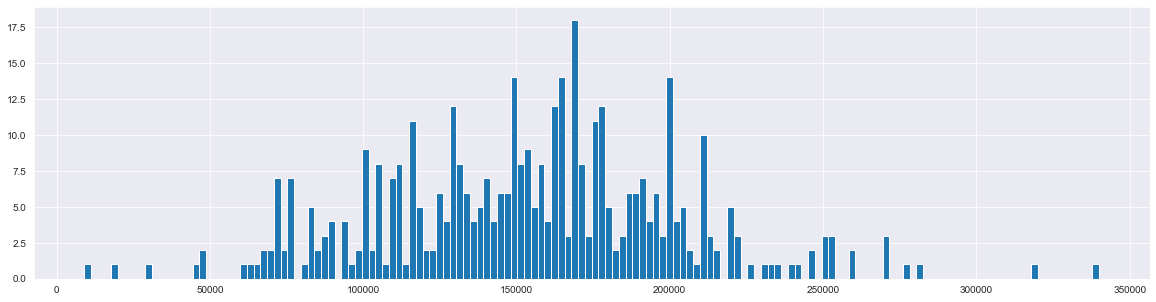

In [458]:
df_mileage = df[df['mileage'] < np.percentile(df['mileage'],99)]
df_mileage['mileage'].hist(bins=150,figsize=(20,5))
plt.show()

In [459]:
df[df['year'] == 2009 ].shape[0]

90

Wall time: 157 ms


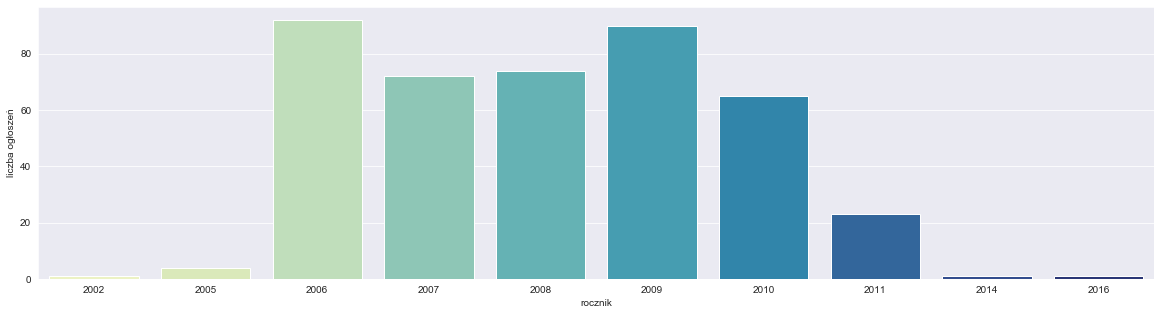

In [460]:
def plot_year():
    year_list = df['year'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['year'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='rocznik', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns.png')
    
%time plot_year()


Wall time: 368 ms


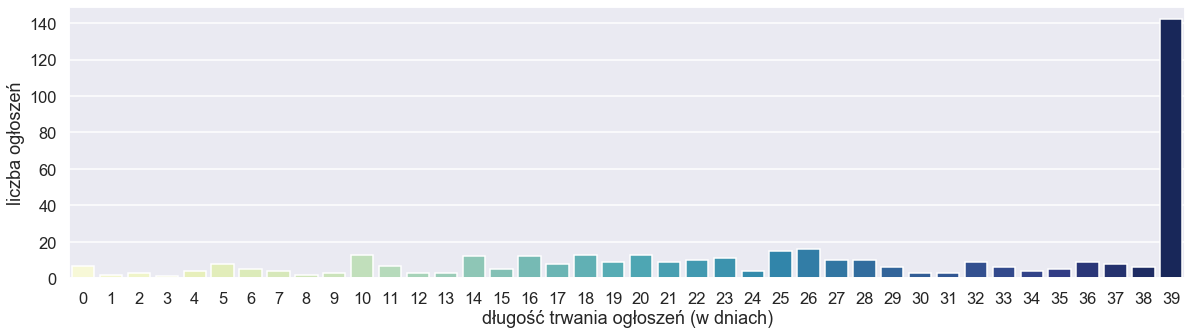

In [461]:
# OTOMOTO
# CZas ogłoszenia 15 / 30 dni

def plot_duration():
    year_list = df['duration'].unique()

    x = []
    y = []
    for i in year_list:
        x.append(i)
        y.append(df[df['duration'] == i ].shape[0])
    
    sdf = pd.DataFrame(dict(x=x, y=y)).sort_values(by=['x'])

    sns.set_style("darkgrid")  
    plt.figure(figsize=(20,5))
    ax = sns.barplot(x=x, y=y, data=sdf, palette=("YlGnBu"))
    ax.set(xlabel='długość trwania ogłoszeń (w dniach)', ylabel='liczba ogłoszeń')
    sns.set_context("talk")
    plt.savefig('sns_duration.png')
    
%time plot_duration()

---

In [462]:
df.columns

Index(['offer_id', 's_date', 'e_date', 'private_business', 'region', 'city',
       'model', 'year', 'mileage', 'engine_capacity', 'vin', 'fuel_type',
       'engine_power', 'gearbox', 'transmission', 'door_count', 'nr_seats',
       'color', 'features', 'price', 'price_raw', 'currency', 'country_origin',
       'registration', 'engine', 'duration', 'price_chng', 'f_', 'f_roof-bars',
       'f_head-display', 'f_alloy-wheels', 'f_gps', 'f_rear-parking-sensors',
       'f_central-lock', 'f_assisted-steering', 'f_rear-electric-windows',
       'f_driver-knee-airbag', 'f_electric-adjustable-seats',
       'f_electronic-rearview-mirrors', 'f_leds', 'f_system-start-stop',
       'f_cd', 'f_park-assist', 'f_shift-paddles', 'f_usb-socket', 'f_abs',
       'f_daytime-lights', 'f_electric-interior-mirror', 'f_automatic-lights',
       'f_automatic-wipers', 'f_towing-hook', 'f_aux-in',
       'f_electric-exterior-mirror', 'f_mp3', 'f_dual-air-conditioning',
       'f_side-window-airbags', 'f_fog-

In [463]:
important_feats = ['offer_id', 's_date', 'e_date', 'private_business','region','city','year', 
                   'mileage', 'fuel_type', 'door_count','f_air-conditioning','f_alloy-wheels',
                  'f_steering-whell-comands','f_front-electric-windows','price', 'price_raw']

df_clean = df.filter(important_feats, axis=1).copy()

df_clean.shape

(423, 16)

## TODO: ML

In [464]:
import random as rn
import xgboost as xgb

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_validate, cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
import scikitplot as skplt

import joblib

seed = 0
np.random.seed(seed)
rn.seed(seed)

xgb_params = {
    'max_depth' : 5, 
    'n_estimators' : 100, 
    'learning_rate' : 0.3, 
    'random_state' : 0
}

model = xgb.XGBRegressor(**xgb_params, objective ='reg:squarederror')

In [465]:
xgb.__version__

'1.0.2'

['private_business', 'year', 'mileage', 'door_count', 'f_air-conditioning', 'f_alloy-wheels', 'f_steering-whell-comands', 'f_front-electric-windows']
Wall time: 138 ms


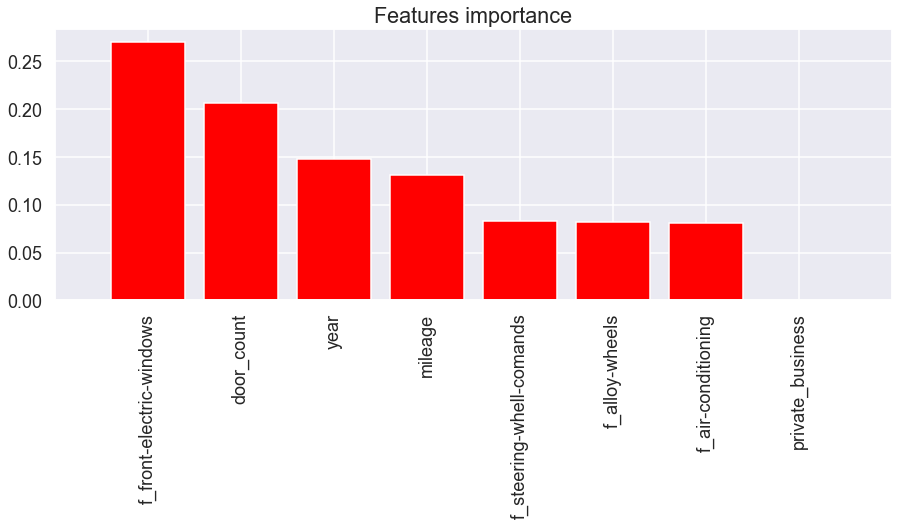

In [466]:
def get_feats(df):
    feats = df.select_dtypes([np.number, np.bool]).columns
    black_list = ['price', 'price_raw', 'offer_id']
    return [x for x in feats if x not in black_list]

def get_cat_feats(df):
    cat_feats = df.select_dtypes(include=[np.object]).columns
    black_list = ['features', 'model']
    cat_feats_list =  [x for x in cat_feats if x not in black_list]

    for cat_feat in cat_feats_list:
        df['{0}_cat'.format(cat_feat)] = pd.factorize( df[cat_feat] )[0]

    
feats = get_feats(df_clean)
print(feats)

X = df_clean[feats].values
y = df_clean['price'].values


def simple_split_model(model, X,y):
    #train and predict
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    skplt.estimators.plot_feature_importances(model, feature_names=feats, title='Features importance', x_tick_rotation=90, figsize=(15, 5));

%time simple_split_model(model, X, y)

In [467]:
df_clean[feats].head(1)

,private_business,year,mileage,door_count,f_air-conditioning,f_alloy-wheels,f_steering-whell-comands,f_front-electric-windows
0,False,2009,111000,5,0,0,0,0


In [468]:
# save model
joblib.dump(model, './models/yaris_200405.pkl') 

['./models/yaris_200405.pkl']

In [475]:
# https://xgboost.readthedocs.io/en/latest/tutorials/saving_model.html
model.save_model('./models/yaris.json')


In [482]:
#['private_business', 'year', 'mileage', 'door_count', 'f_air-conditioning', 'f_alloy-wheels', 'f_steering-whell-comands', 'f_front-electric-windows']
car_info = pd.DataFrame(columns = feats)

car_details = {
    'private_business' : 0,
    'year' : 2008,
    'mileage' : 142000, 
    'door_count' : 3, 
    'f_air-conditioning' : 1, 
    'f_alloy-wheels': 0, 
    'f_steering-whell-comands' : 0, 
    'f_front-electric-windows' : 0
}

car_info = car_info.append(car_details , ignore_index=True)
car_info

,private_business,year,mileage,door_count,f_air-conditioning,f_alloy-wheels,f_steering-whell-comands,f_front-electric-windows
0,1,2008,142000,3,1,0,0,0


In [486]:
y_pred = model.predict(car_info.values)
print('Cena powinna wynosić: ', y_pred[0], 'zł')

Cena powinna wynosić:  13470.159 zł


In [485]:
#load model & predict
loaded_model = joblib.load('./models/yaris_200405.pkl')
result = loaded_model.predict(car_info.values)
print('Cena powinna wynosić: ',result[0], 'zł')

Cena powinna wynosić:  13470.159 zł


In [476]:
print(X[0].shape)

(8,)


In [304]:
get_cat_feats(df_clean)
feats = get_feats(df_clean)
print(feats)

['private_business', 'year', 'mileage', 'door_count', 'f_air-conditioning', 'f_alloy-wheels', 'f_steering-whell-comands', 'f_front-electric-windows', 'region_cat', 'city_cat', 'fuel_type_cat']
